In [1]:
"""
Script for parsing logs
"""

import os
import sys
sys.path.append(os.path.abspath('../utility'))

import yaml
import json
import pprint
import humanize
import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sb
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from const import *
from collections import OrderedDict

## Seaborn aesthetics
sb.set_context(
    "talk",
    font_scale=1,
    rc={
        "lines.linewidth": 1,
        "text.usetex": True,
        "font.family": 'serif',
        "font.serif": 'Palatino',
        "font.size": 16
    })
sb.set_style("whitegrid")

stats = {}
link_stats = {}
accuracy_lag = None

In [2]:
"""
Set Log file and config file
"""

log_path = "../logs/20190316-2244"
# log_path = "../logs/20190317-1625-1-2-4-simple"
# log_path = "../logs/20190317-1802-1-2-4-simple"


log_file, config_file = None, None
try:
    for file in os.listdir(log_path):
        if file.endswith(".log"): log_file = os.path.join(log_path, file)
        if file.endswith(".yaml"): config_file = os.path.join(log_path, file)
except FileNotFoundError:
    print("Log Directory not found"); exit(0)

if log_file is None or config_file is None:
    print("Invalid Log directory");	exit(0)

In [3]:
"""
Read yaml from config file
"""

with open(config_file, 'r') as f:

    raw_data = yaml.load(f.read())
    tree = {}

    for x in raw_data['nodes']:
        tree[x['id']] = x
        tree[x['id']]['is_worker'] = True
        tree[x['id']]['children_count'] = 0

    for x in raw_data['nodes']:

        if 'parent_id' in x:
            tree[x['parent_id']]['is_worker'] = False
            tree[x['parent_id']]['children_count'] += 1
        else:
            tree[x['id']]['parent_id'] = -1

config = tree

In [4]:
"""
Collect data
"""

f = open(log_file, 'r')

accuracy_lag = {}
for node_id in config:
    if not config[node_id]['is_worker']:
        accuracy_lag.update({node_id:OrderedDict()})
window_lags_pointer = { node_id:0 for node_id in config }
base_timestamp, final_timestamp = None, None

for row in f:

    data = json.loads(row)
    node_id, payload, timestamp = data[NODE_ID], data[PAYLOAD], data[TIMESTAMP]
    parent_id = config[node_id]['parent_id']

    if base_timestamp is None: base_timestamp = timestamp
    final_timestamp = timestamp

    if data[TYPE] == STATISTIC:

        ## Calculate Accuracy and timestamp
        if node_id in stats: 
            stats[node_id][TIMESTAMP].append(timestamp - base_timestamp)
            try:
                for test_file in payload[ACCURACY]:
                    stats[node_id][ACCURACY][test_file].append(payload[ACCURACY][test_file])
            except:
                for test_file in payload[POST_MERGE_ACCURACY]:
                    stats[node_id][ACCURACY][test_file].append(payload[POST_MERGE_ACCURACY][test_file])
        else:
            try:
                stats[node_id] = {
                    ACCURACY 		: { test_file:[a] for test_file,a in payload[ACCURACY].items() },
                    TIMESTAMP 		: [timestamp - base_timestamp]
                }
            except:
                stats[node_id] = {
                    ACCURACY 		: { test_file:[a] for test_file,a in payload[POST_MERGE_ACCURACY].items() },
                    TIMESTAMP 		: [timestamp - base_timestamp]
                }

        ##Calculate Runtime, Process time and total datapoints (if node is a worker)
        if config[node_id]['is_worker']:
            if RUNTIME in stats[node_id]:
                stats[node_id][RUNTIME] += payload[RUNTIME]
                stats[node_id][PROCESS_TIME] += payload[PROCESS_TIME] 
                stats[node_id][DATAPOINTS] += payload[DATAPOINTS]
            else:
                stats[node_id][RUNTIME] = payload[RUNTIME]
                stats[node_id][PROCESS_TIME] =  payload[PROCESS_TIME]
                stats[node_id][DATAPOINTS] = payload[DATAPOINTS]

    elif data[TYPE] == PROCESSED:		
        ## Calculate accuracy lag - Part 1 (Store window processing timestamp)
        if config[node_id]['is_worker']:
            ## Log which indicates window is processed
            window_id = payload[WINDOW_ID]

            if window_id not in accuracy_lag[parent_id]:
                accuracy_lag[parent_id][window_id] = { 
                    node_id: timestamp 
                }
            else:
                accuracy_lag[parent_id][window_id].update({node_id:timestamp})
                
    elif data[TYPE] == PUSHED:
        ## Calculate network cost
        if NETWORK_COST in payload:
            if (parent_id, node_id) in link_stats:
                link_stats[(parent_id, node_id)] += payload[NETWORK_COST]
            else:
                link_stats[(parent_id, node_id)] = payload[NETWORK_COST]

    elif data[TYPE] == PULLED:
        
        ## Calculate network cost
        if NETWORK_COST in payload:
            if (parent_id, node_id) in link_stats:
                link_stats[(parent_id, node_id)] += payload[NETWORK_COST]
            else:
                link_stats[(parent_id, node_id)] = payload[NETWORK_COST]
                
        ## Calculate accuracy lag - Part 2 (Receive model from parent)
        if config[node_id]['is_worker']:
            ## Log which indicates model receival
            lag_pointer = window_lags_pointer[node_id]
            if lag_pointer in accuracy_lag[parent_id]:
                while lag_pointer in accuracy_lag[parent_id] and len(accuracy_lag[parent_id][lag_pointer]) == config[parent_id]['children_count']:
                    accuracy_lag[parent_id][lag_pointer][node_id] = timestamp - accuracy_lag[parent_id][lag_pointer][node_id]
                    lag_pointer += 1
                window_lags_pointer[node_id] = lag_pointer

num_nodes = len(stats)
num_workers = sum([1 if v['is_worker'] else 0 for k,v in config.items()])
f.close()

In [5]:
"""
Print yaml
"""

with open(config_file, 'r') as f:
    print(yaml.dump(yaml.load(f.read()), default_flow_style=False))

application_arguments:
- alpha: 0.4
  batch_size: 20
  epochs: 10
  hidden_layer_sizes:
  - 20
  - 10
  - 10
  input_size: 784
  model: MNIST
  num_hidden_layers: 3
  output_size: 10
bandwidths:
- bandwidth: 1000000
  dest_id: 2
  src_id: 1
default_args: 0
default_bandwidth: 1000000
default_cpus: 1
default_docker_image: aniketshirke/distributedlearning:simulator
default_host_test_directory: ~/Simulator/mnist_data/test
default_kafka_server: 10.129.2.26:9092
default_memory: 400M
default_policy: 1
default_test_directory: /TreeNN/data/
default_window_interval: 20
default_window_limit: 100
machine:
- ip: 10.129.26.111
  password: spark!sfun
  username: ub
nodes:
- id: 1
  machine: 0
  port: 8000
- id: 2
  machine: 0
  parent_id: 1
  port: 8006
  sensors:
  - 0
- id: 3
  machine: 0
  parent_id: 1
  port: 8007
  sensors:
  - 1
policy:
- args: null
  type: SimplePolicy
- args:
    wait_interval: 120
  type: WaitPolicy
- args:
    pull_interval: 10
    push_interval: 10
  type: TimePolicy
- arg

In [6]:
"""
Print Statistics
"""
from IPython.display import display, HTML

experiment_duration = humanize.naturaldelta(datetime.timedelta(seconds=final_timestamp - base_timestamp))

print("\t\t\t\t\tExperiment Information")
print("Experiment duration: %s"%experiment_duration)
exp_info = pd.DataFrame(columns=['Runtime', 'Process time', 'Average Datapoints per Window'], index=stats.keys())

for node_id, info in stats.items():
    if config[node_id]['is_worker']:
        runtime = humanize.naturaldelta(datetime.timedelta(seconds=info[RUNTIME]))
        process_time = humanize.naturaldelta(datetime.timedelta(seconds=info[PROCESS_TIME]))
        datapoints = info[DATAPOINTS]
        exp_info.loc[node_id] = [runtime, process_time, datapoints/len(info)]
exp_info.index.name='Node ID'        

exp_info.fillna(value='-', inplace=True)
display(HTML(exp_info.to_html()))




					Experiment Information
Experiment duration: 25 minutes


,Runtime,Process time,Average Datapoints per Window
Node ID,,,
1,-,-,-
2,23 minutes,15 minutes,5507.6
3,24 minutes,15 minutes,5682.6


In [7]:
"""
Print Link Statistics
"""
from IPython.display import display, HTML

link_matrix = pd.DataFrame(np.empty(shape=(num_nodes,num_nodes), dtype=object), columns=stats.keys(), index=stats.keys())

for (s,d) in link_stats:
    link_matrix.at[s,d] = humanize.naturalsize(link_stats[(s,d)], gnu=True)
    link_matrix.at[d,s] = humanize.naturalsize(link_stats[(s,d)], gnu=True)

link_matrix.fillna(value='-', inplace=True)

print("\t\t\tNetwork Cost\n")    
display(HTML(link_matrix.to_html()))


			Network Cost



,1,2,3
1,-,6.0M,6.2M
2,6.0M,-,-
3,6.2M,-,-


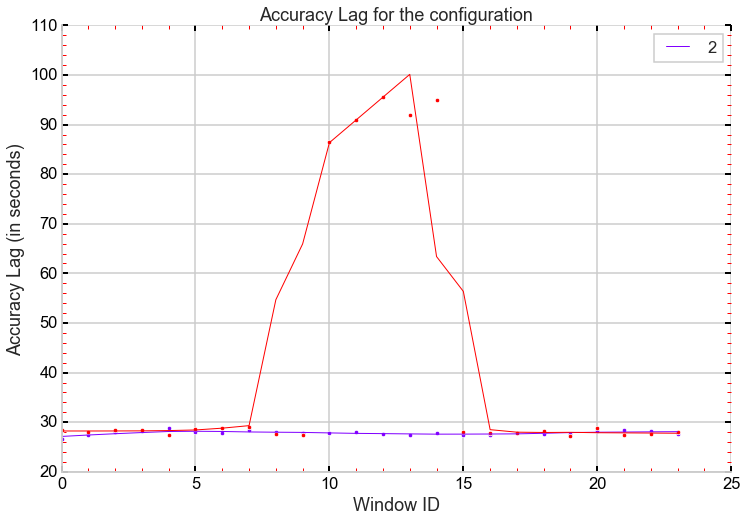

In [8]:
"""
Plot Accuracy Lag
"""

## Reshape dictionary for visualization and filter out odd values of accuracy lag (at the end)
modified_accuracy_lag = {}
for node_id in config: 
    if config[node_id]['is_worker']:
        modified_accuracy_lag.update({node_id: []})

for parent_id in accuracy_lag:
    for window_id in accuracy_lag[parent_id]:
        for node_id in accuracy_lag[parent_id][window_id]:
            lag = accuracy_lag[parent_id][window_id][node_id]
            if lag < base_timestamp:
                modified_accuracy_lag[node_id].append((window_id, lag))

## Graph colors
plt.figure(figsize=(12, 8))
base_colors = cm.rainbow(np.linspace(0, 1,len(modified_accuracy_lag))) #For the case of MNIST and one level of heirarchy
colors = dict(list(zip(modified_accuracy_lag.keys(), base_colors)))

for node_id in modified_accuracy_lag:
    [window_ids, lags] = zip(*modified_accuracy_lag[node_id])
    window_ids, lags = list(window_ids), list(lags)
    
    ## Scatterplot in the background
    ax = sb.scatterplot(window_ids,lags, color=colors[node_id])
    
    ## Smooth fit to the data
    lowess = sm.nonparametric.lowess(lags, window_ids, frac=0.4)
    [lowess_x, lowess_y] = list(zip(*lowess))
    plt.plot(lowess_x, lowess_y, color=colors[node_id], label=node_id)
    
## Axes aesthetics
ax.tick_params(direction='in', length=6, width=2, colors='k', which='major')
ax.tick_params(direction='in', length=4, width=1, colors='r', which='minor')
ax.minorticks_on() 
sb.despine()

plt.title('Accuracy Lag for the configuration')
plt.xlabel('Window ID')
plt.ylabel('Accuracy Lag (in seconds)')
plt.xlim(0)
plt.show()
plt.clf()


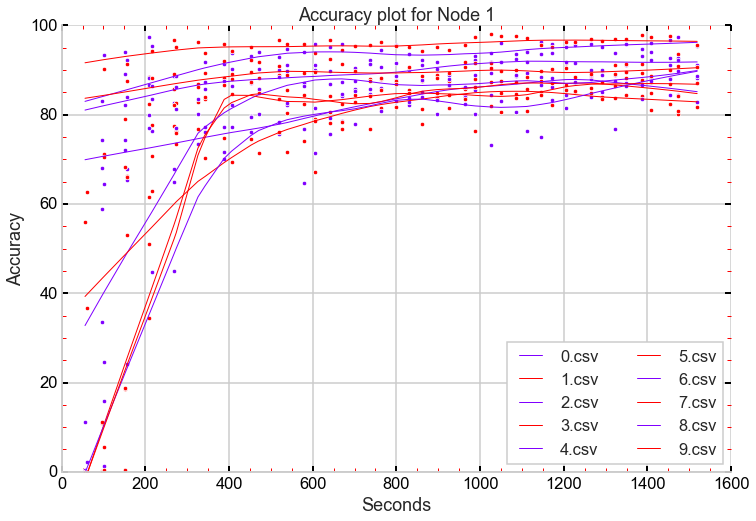

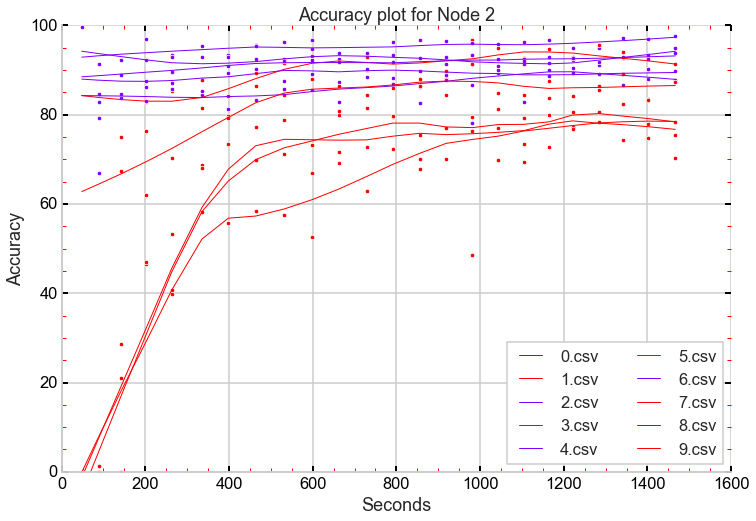

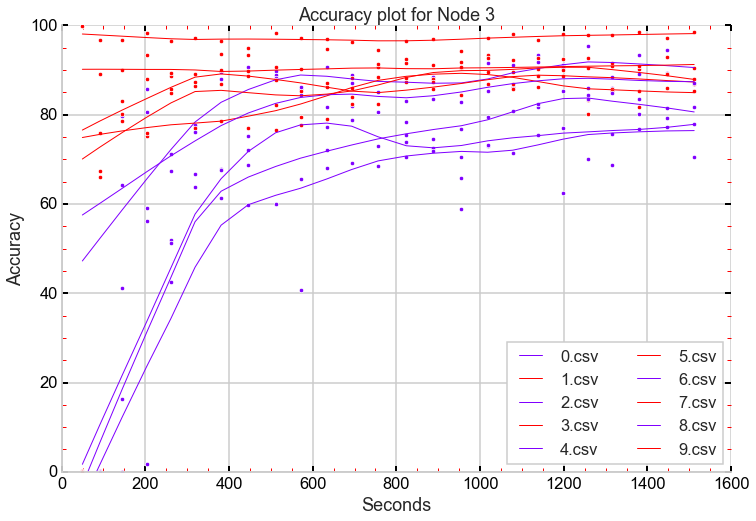

In [9]:
"""
Plot Accuracy
"""

base_colors = cm.rainbow(np.linspace(0, 1,num_workers))

for node_id, stat in stats.items():
    
    ## Init plot and colormap
    plt.figure(figsize=(12, 8))
    colors = [base_colors[i%num_workers] for i in range(len(stat[ACCURACY]))]
    #colors = cm.Accent(np.linspace(0, 1, len(stat[ACCURACY])))
    
    ## Plotting
    files = OrderedDict(sorted(stat[ACCURACY].items()))    
    for f,c in zip(files,colors):
        
        ## Scatterplot in the background
        ax = sb.scatterplot(np.array(stat[TIMESTAMP]),np.array(stat[ACCURACY][f]),color=c)
        
        ## Smooth fit to the data
        lowess = sm.nonparametric.lowess(np.array(stat[ACCURACY][f]), np.array(stat[TIMESTAMP]), frac=0.4)
        [lowess_x, lowess_y] = list(zip(*lowess))
        plt.plot(lowess_x, lowess_y, color=c, label=f)

    ## Axes aesthetics
    ax.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    ax.tick_params(direction='in', length=4, width=1, colors='r', which='minor')
    ax.minorticks_on() 
    sb.despine()
    
    plt.title('Accuracy plot for Node %d'%node_id)
    plt.xlabel('Seconds')
    plt.ylabel('Accuracy')
    plt.xlim(0)
    plt.ylim(0,100)
    plt.legend(ncol=2, loc='lower right')
    
    plt.show()
    plt.clf()